In [1]:
# Generic inputs for most ML tasks
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator, TransformerMixin
import ipaddress

from datetime import datetime

pd.options.display.float_format = '{:,.2f}'.format

# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
traffic_df = pd.read_csv('FinalCombined.csv')

In [3]:
traffic_df['Label'].value_counts()

Label
BHijacking          55957
CommandInjection    51731
SqlInjection        49995
Mirai               49836
DDos                49541
Benign              48069
Name: count, dtype: int64

## Data Cleansing

### Finding missing columns in data

In [4]:
nan_columns = traffic_df.columns[traffic_df.isna().any()].tolist()
nan_columns

['SourcePort', 'DstPort']

### Imputing missing ports with mode value

In [5]:
# Mode Imputation for ports
source_port_mode = traffic_df['SourcePort'].mode()[0]
dest_port_mode = traffic_df['DstPort'].mode()[0]

traffic_df['SourcePort'].fillna(source_port_mode, inplace=True)
traffic_df['DstPort'].fillna(dest_port_mode, inplace=True)

## Feature Engineering


In [6]:
class IPAddressCategoryTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def categorize_ip(ip):
            try:
                parsed_ip = ipaddress.ip_address(ip)
                if parsed_ip.is_private:
                    return 0  # Private
                elif parsed_ip.is_global:
                    return 1  # Public
                elif parsed_ip.is_multicast:
                    return 2  # Multicast
                else:
                    return 3  # Other
            except ValueError:
                return 4  # Invalid

        X = X.copy()
        X['SourceIPCategory'] = X['SourceIP'].apply(categorize_ip)
        X['DestIPCategory'] = X['DestIP'].apply(categorize_ip)
        return X

class CommonPortFlagTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        common_ports = [80, 443]  # You can add more common ports here
        X = X.copy()
        X['SourcePortCommon'] = X['SourcePort'].isin(common_ports).astype(int)
        X['DestPortCommon'] = X['DstPort'].isin(common_ports).astype(int)
        return X


class TemporalFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['HourOfDay'] = pd.to_datetime(X['Time']).dt.hour
        X['DayOfWeek'] = pd.to_datetime(X['Time']).dt.dayofweek
        return X

class TrafficFlowFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['BytesRatio'] = X['SourceIPBytes'] / (X['DestIPBytes'] + 1)  # Adding 1 to avoid division by zero
        X['LengthToPortRatio'] = X['Length'] / (X['SourcePort'] + X['DstPort'] + 1)
        return X

class RateFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['CombinedRate'] = X['Srate'] + X['Drate']
        X['RateDifference'] = X['Srate'] - X['Drate']
        return X



In [7]:
# Assuming df is your original DataFrame

# Initialize transformers
ip_transformer = IPAddressCategoryTransformer()
port_transformer = CommonPortFlagTransformer()
temporal_transformer = TemporalFeaturesTransformer()
traffic_flow_transformer = TrafficFlowFeaturesTransformer()
rate_transformer = RateFeaturesTransformer()

# Apply transformations
traffic_df = ip_transformer.transform(traffic_df)
traffic_df = port_transformer.transform(traffic_df)
traffic_df = temporal_transformer.transform(traffic_df)
traffic_df = traffic_flow_transformer.transform(traffic_df)
traffic_df = rate_transformer.transform(traffic_df)


In [8]:
traffic_df

,Label,Time,SourceIP,SourcePort,DestIP,DstPort,Protocol,Length,SourceIPBytes,DestIPBytes,Srate,Drate,SourceIPCategory,DestIPCategory,SourcePortCommon,DestPortCommon,HourOfDay,DayOfWeek,BytesRatio,LengthToPortRatio,CombinedRate,RateDifference
0,BHijacking,"1,701,736,154.52",192.168.137.49,"56,618.00",35.81.189.105,443.00,6,66,14,13,0.00,0.00,0,1,0,1,0,3,1.00,0.00,0.00,0.00
1,BHijacking,"1,701,736,154.52",192.168.137.121,"39,918.00",34.158.253.218,"4,070.00",6,77,15,14,"124,923.43","116,595.20",0,1,0,0,0,3,1.00,0.00,"241,518.62","8,328.23"
2,BHijacking,"1,701,736,154.52",192.168.137.228,"43,782.00",192.168.137.1,53.00,17,80,15,13,"210,416.59","182,361.04",0,0,0,0,0,3,1.07,0.00,"392,777.63","28,055.55"
3,BHijacking,"1,701,736,154.52",192.168.137.228,"50,083.00",192.168.137.1,53.00,17,80,15,13,"207,296.74","179,657.17",0,0,0,0,0,3,1.07,0.00,"386,953.91","27,639.57"
4,BHijacking,"1,701,736,154.52",35.81.189.105,443.00,192.168.137.49,"56,618.00",6,66,13,14,"301,456.54","324,645.51",1,0,1,0,0,3,0.87,0.00,"626,102.05","-23,188.96"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305124,Benign,"1,701,736,275.04",44.231.109.193,443.00,192.168.137.78,"48,765.00",6,66,14,14,"644,392.38","644,392.38",1,0,1,0,0,3,0.93,0.00,"1,288,784.77",0.00
305125,Benign,"1,701,736,275.04",192.168.137.46,"57,480.00",35.185.101.66,443.00,6,156,14,13,"639,132.04","593,479.75",0,1,0,1,0,3,1.00,0.00,"1,232,611.79","45,652.29"
305126,Benign,"1,701,736,275.04",192.168.137.175,"57,442.00",52.19.77.30,443.00,6,1514,15,11,"523,742.43","384,077.79",0,1,0,1,0,3,1.25,0.03,"907,820.22","139,664.65"
305127,Benign,"1,701,736,275.04",192.168.137.175,"57,442.00",52.19.77.30,443.00,6,1048,15,11,"504,830.97","370,209.38",0,1,0,1,0,3,1.25,0.02,"875,040.35","134,621.59"


In [9]:
# from pandas.plotting import scatter_matrix

# scatter_matrix(traffic_df[list(traffic_df.columns)], figsize=(12, 8))

## Data Preparation

### Getting parts of the time in numerical formats

In [10]:
traffic_df['Time'] = traffic_df['Time'].apply(lambda x: datetime.utcfromtimestamp(float(x)).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])

In [11]:
traffic_df['Time'] = pd.to_datetime(traffic_df['Time'])

In [12]:
# Extract components
traffic_df['year'] = traffic_df['Time'].dt.year
traffic_df['month'] = traffic_df['Time'].dt.month
traffic_df['day'] = traffic_df['Time'].dt.day
traffic_df['hour'] = traffic_df['Time'].dt.hour
traffic_df['minute'] = traffic_df['Time'].dt.minute
traffic_df['second'] = traffic_df['Time'].dt.second
traffic_df['day_of_week'] = traffic_df['Time'].dt.dayofweek
traffic_df['week_of_year'] = traffic_df['Time'].dt.isocalendar().week
traffic_df['is_weekend'] = traffic_df['day_of_week'].apply(lambda x: 1 if x > 4 else 0)
traffic_df['time_of_day'] = traffic_df['hour'] + traffic_df['minute'] / 60 + traffic_df['second'] / 3600
traffic_df['unix_timestamp'] = traffic_df['Time'].astype(int) / 10**9

### Numerically encoding the Ip addresses by converting each octet of an IP address into its equivalent 32-bit long integer representation 

In [13]:
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return None  # or some sentinel value you choose

traffic_df['SourceIP_int'] = traffic_df['SourceIP'].apply(ip_to_int)
traffic_df['DestIP_int'] = traffic_df['DestIP'].apply(ip_to_int)

In [14]:
traffic_df.drop(['Time', 'SourceIP', 'DestIP'], axis=1, inplace=True)

# Understanding the data through visualization

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Protocol'>

Text(0.5, 1.0, 'Protocol Distribution')

Text(0.5, 0, 'Protocol')

Text(0, 0.5, 'Count')

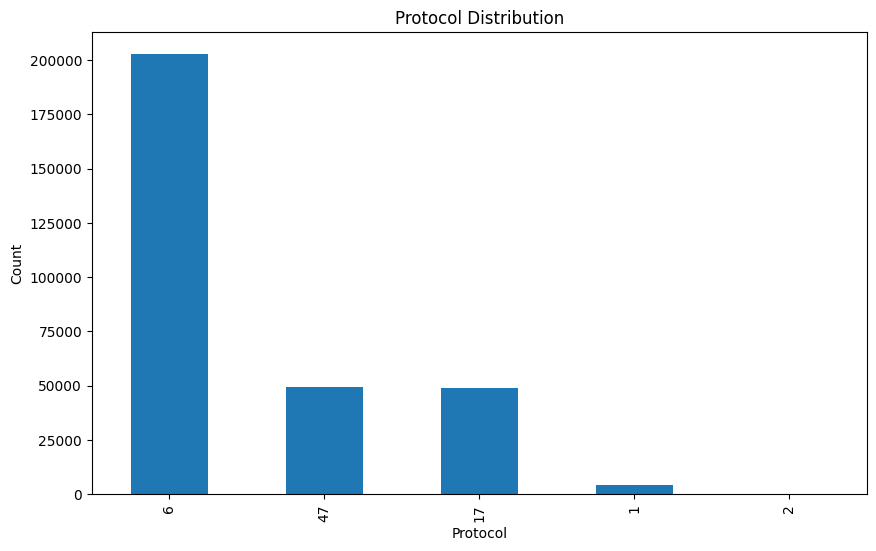

In [15]:
#Understand the distribution of different network protocols used in the traffic
plt.figure(figsize=(10, 6))
traffic_df['Protocol'].value_counts().plot(kind='bar')
plt.title('Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.show()

<Figure size 800x800 with 0 Axes>

<Axes: ylabel='count'>

Text(0.5, 1.0, 'Traffic Type Distribution')

Text(0, 0.5, '')

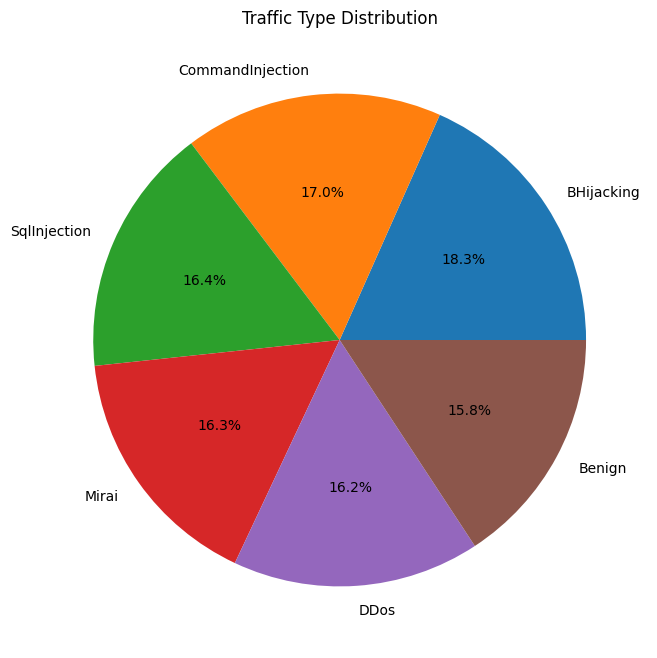

In [16]:
# Checking for balance or imbalance between classes
plt.figure(figsize=(8, 8))
traffic_df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Traffic Type Distribution')
plt.ylabel('')  # Hide y-label as it's unnecessary for pie charts
plt.show()

### From the above plot, it is clear that our data is imbalance and machine learning model and neural networks might be biased towards the majority class to minimize over all error.

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='SourceIPBytes', ylabel='DestIPBytes'>

Text(0.5, 1.0, 'Source vs Destination IP Bytes')

Text(0.5, 0, 'Source IP Bytes')

Text(0, 0.5, 'Destination IP Bytes')

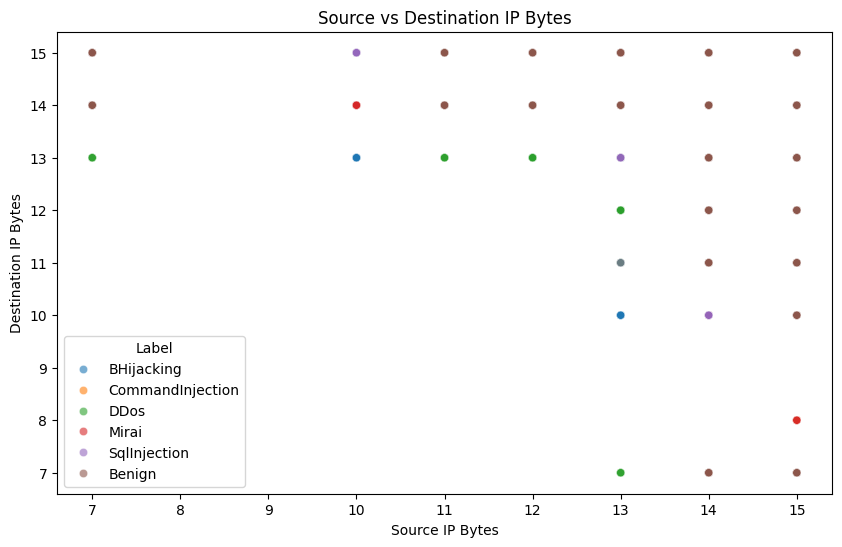

In [17]:
# Patterns or correlations between the amount of data sent from source IPs and received by destination IPs
plt.figure(figsize=(10, 6))
sns.scatterplot(data=traffic_df, x='SourceIPBytes', y='DestIPBytes', hue='Label', alpha=0.6)
plt.title('Source vs Destination IP Bytes')
plt.xlabel('Source IP Bytes')
plt.ylabel('Destination IP Bytes')
plt.show()

<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Label', ylabel='Length'>

Text(0.5, 1.0, 'Packet Length Distribution by Traffic Type')

Text(0.5, 0, 'Traffic Type')

Text(0, 0.5, 'Packet Length')

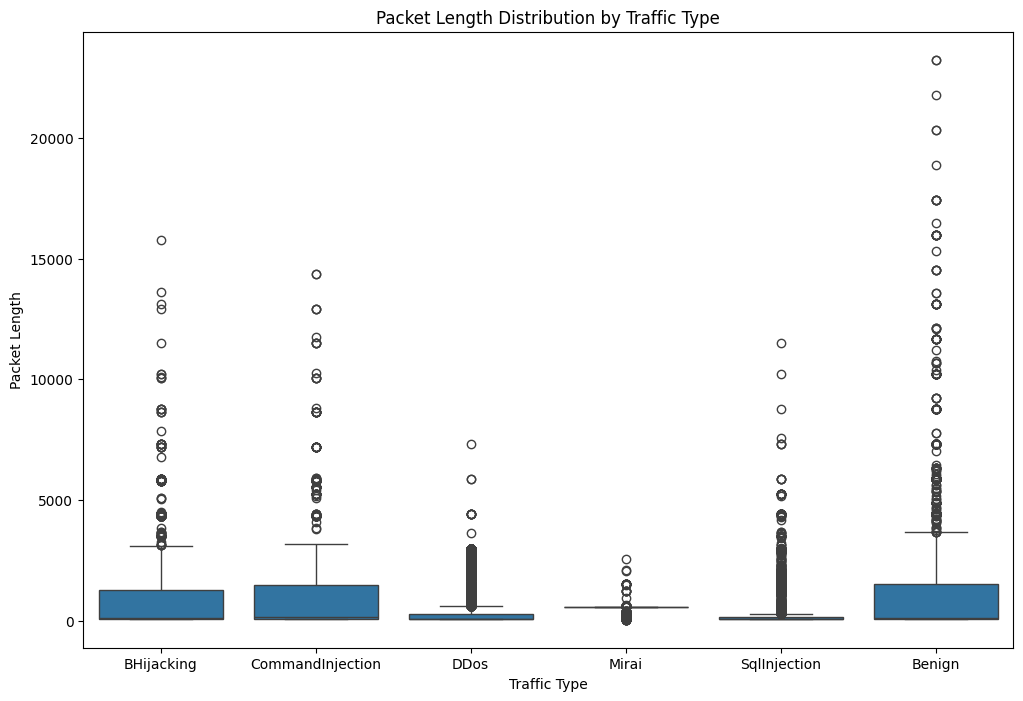

In [18]:
# Check for outliers in the distribution of packet lengths for different types of traffic

plt.figure(figsize=(12, 8))
sns.boxplot(x='Label', y='Length', data=traffic_df)
plt.title('Packet Length Distribution by Traffic Type')
plt.xlabel('Traffic Type')
plt.ylabel('Packet Length')
plt.show()

<Figure size 1500x1500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Feature Correlation Matrix')

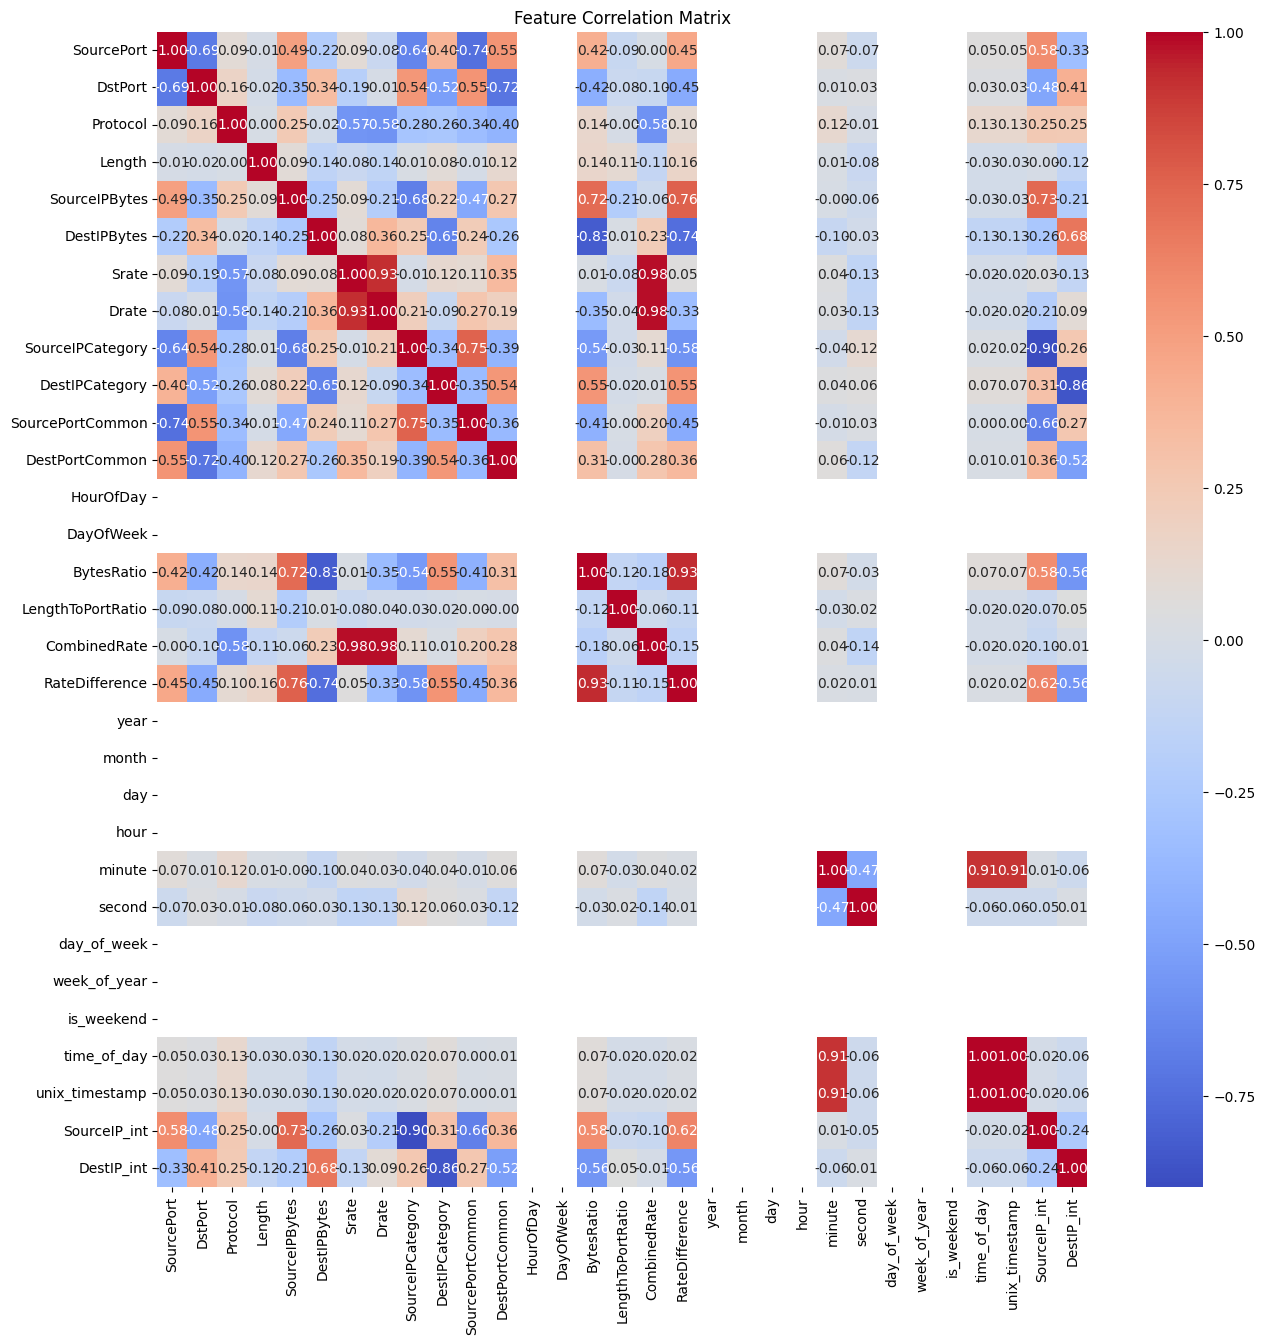

In [19]:
# Matrix heatmap to visualize the correlation coefficients between variables
plt.figure(figsize=(15, 15))
sns.heatmap(traffic_df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## Stratified Shuffling and splitting of data into training and test sets

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(traffic_df, traffic_df["Label"]):
    strat_train_set = traffic_df.loc[train_index]
    strat_test_set = traffic_df.loc[test_index]

In [29]:
print("---------Training Set----------")
print(strat_train_set.count())
print("---------Test Set----------")
print(strat_test_set.count())

---------Training Set----------
Label                244103
SourcePort           244103
DstPort              244103
Protocol             244103
Length               244103
SourceIPBytes        244103
DestIPBytes          244103
Srate                244103
Drate                244103
SourceIPCategory     244103
DestIPCategory       244103
SourcePortCommon     244103
DestPortCommon       244103
HourOfDay            244103
DayOfWeek            244103
BytesRatio           244103
LengthToPortRatio    244103
CombinedRate         244103
RateDifference       244103
year                 244103
month                244103
day                  244103
hour                 244103
minute               244103
second               244103
day_of_week          244103
week_of_year         244103
is_weekend           244103
time_of_day          244103
unix_timestamp       244103
SourceIP_int         244103
DestIP_int           244103
dtype: int64
---------Test Set----------
Label                61026
Sour

In [21]:
train_set = strat_train_set.drop("Label", axis=1) # Features
train_set_labels = strat_train_set["Label"].copy() # Multi Class Labels

test_set = strat_test_set.drop("Label", axis=1) # Features
test_set_labels = strat_test_set["Label"].copy() # Multi Class Labels

In [31]:
train_set_labels

236178        SqlInjection
147633                DDos
38241           BHijacking
247618        SqlInjection
194323               Mirai
                ...       
38557           BHijacking
303129              Benign
154434                DDos
82384     CommandInjection
225405        SqlInjection
Name: Label, Length: 244103, dtype: object

### Standardizing and Normalizing for application of different machine learning models and neural networks

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardizing the features for supervised and unsupervised models
scaler = StandardScaler()
train_set_scaled = scaler.fit_transform(train_set)

# Normalizing the features for Neural Networks
scaler = MinMaxScaler()
train_set_normalized = scaler.fit_transform(train_set)

# Standardizing the features for supervised and unsupervised models
test_set_scaled = scaler.fit_transform(test_set)

# Normalizing the features for Neural Networks
test_set_normalized = scaler.fit_transform(test_set)

## Class Weight for dealing with data imbalances

In [24]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

# Encoding the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_set_labels)

# Calculate the current ratio of benign to other classes
benign_count = np.sum(train_set_labels == 'Benign')
other_count = len(train_set_labels) - benign_count
ratio = other_count / benign_count

# Set the benign class to have a smaller weight
# and significantly higher weights to the underrepresented classes '2' and '5'
class_weight = {
    label_encoder.transform(['Benign'])[0]: 1,
    label_encoder.transform(['CommandInjection'])[0]: ratio * 10,  # Replace 'Class2Name' with the actual class name
    label_encoder.transform(['SqlInjection'])[0]: ratio * 10   # Replace 'Class5Name' with the actual class name
}

# Other classes can have weights proportional to their representation
for cls in label_encoder.classes_:
    if cls not in ['Benign', 'CommandInjection', 'SqlInjection']:  # Replace with actual class names
        cls_index = label_encoder.transform([cls])[0]
        cls_count = np.sum(train_set_labels == cls)
        cls_ratio = other_count / cls_count
        class_weight[cls_index] = cls_ratio

print("Class weights: ", class_weight)

Class weights:  {1: 1, 2: 53.47757118710181, 5: 53.47757118710181, 0: 4.593946163297219, 3: 5.1888073070421115, 4: 5.158092753768592}


## Tuning Hyperparameters using Random Search

In [97]:
print(train_set_labels.value_counts())

Label
Browser Hijack       44765
Command Injection    41385
DDoS                 39633
Benign               38455
Backdoor             24319
Name: count, dtype: int64
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  25.6s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  24.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  29.2s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  52.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=  36.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  18.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  39.3s
[C

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter space to sample from
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier object
rf = RandomForestClassifier(random_state=42)

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, n_iter=2, cv=3, 
                                   verbose=2, random_state=42, n_jobs=-1)

# Fit it to the training data
random_search.fit(train_set_scaled, train_set_labels)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

# Evaluate the best model found by RandomizedSearchCV on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(test_set_scaled)

# Print the evaluation report
print(classification_report(test_set_labels, y_pred))
print("Accuracy:", accuracy_score(test_set_labels, y_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

Best parameters found:  {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Best score:  1.0


/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

      BHijacking       0.00      0.00      0.00     11192
          Benign       0.00      0.00      0.00      9614
CommandInjection       0.00      0.00      0.00     10346
            DDos       0.00      0.00      0.00      9908
           Mirai       0.24      0.97      0.38      9967
    SqlInjection       0.50      1.00      0.67      9999

        accuracy                           0.32     61026
       macro avg       0.12      0.33      0.17     61026
    weighted avg       0.12      0.32      0.17     61026

Accuracy: 0.3221905417363091


/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Encoding the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_set_labels)
encoded_test_labels = label_encoder.fit_transform(test_set_labels)

# Define the pipeline steps
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, class_weight=class_weight))
])

# Define the parameter grid to search
param_distributions = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=2,
    cv=3,
    scoring='f1_macro',  # Consider using a scoring function that takes class imbalance into account
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit it to the training data
random_search.fit(train_set_scaled, encoded_labels)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

# Evaluate the best model found by RandomizedSearchCV on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(test_set_scaled)

# Print the evaluation report
print(classification_report(encoded_test_labels, y_pred))
print("Accuracy:", accuracy_score(encoded_test_labels, y_pred))


Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('rf',
                                              RandomForestClassifier(class_weight={0: 4.593946163297219,
                                                                                   1: 1,
                                                                                   2: 53.47757118710181,
                                                                                   3: 5.1888073070421115,
                                                                                   4: 5.158092753768592,
                                                                                   5: 53.47757118710181},
                                                                     random_state=42))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__max_depth': [None, 10, 20, 30, 40,
                                                          50],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [100, 200, 300, 400,
                                                             500]},
                   random_state=42, scoring='f1_macro', verbose=2)

Best parameters found:  {'rf__n_estimators': 300, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20, 'rf__bootstrap': True}
Best score:  1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11192
           1       0.00      0.00      0.00      9614
           2       0.00      0.00      0.00     10346
           3       0.00      0.00      0.00      9908
           4       0.24      0.97      0.38      9967
           5       0.50      1.00      0.67      9999

    accuracy                           0.32     61026
   macro avg       0.12      0.33      0.17     61026
weighted avg       0.12      0.32      0.17     61026

Accuracy: 0.32220692819454005


/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Using Logistic Regression

In [31]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Initialize the Logistic Regression model for multiclass classification
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

# Fit the Logistic Regression model
log_reg.fit(train_set_scaled, train_set_labels)

# Make predictions on the test set
predictions = log_reg.predict(test_set_scaled)

# Calculate metrics
accuracy = accuracy_score(test_set_labels, predictions)
precision = precision_score(test_set_labels, predictions, average='weighted', zero_division=0)
recall = recall_score(test_set_labels, predictions, average='weighted', zero_division=0)
f1 = f1_score(test_set_labels, predictions, average='weighted', zero_division=0)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print a detailed classification report
print("\nClassification Report:\n")
print(classification_report(test_set_labels, predictions, zero_division=0))

LogisticRegression(max_iter=1000, multi_class='multinomial')

Accuracy: 0.30744272932848293
Precision: 0.12037466708607342
Recall: 0.30744272932848293
F1 Score: 0.17300242760224632

Classification Report:

                  precision    recall  f1-score   support

      BHijacking       0.00      0.00      0.00     11192
          Benign       0.00      0.00      0.00      9614
CommandInjection       0.00      0.00      0.00     10346
            DDos       0.00      0.00      0.00      9908
           Mirai       0.34      0.88      0.49      9967
    SqlInjection       0.40      1.00      0.57      9999

        accuracy                           0.31     61026
       macro avg       0.12      0.31      0.18     61026
    weighted avg       0.12      0.31      0.17     61026



## Running XGBoost Algorithm

In [32]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Your data: train_set_features (features) and train_set_labels (labels)

# Convert labels to numeric values
le = LabelEncoder()
encoded_labels = le.fit_transform(train_set_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_set_scaled, encoded_labels, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob',  # Using 'multi:softmax' for hard classification, 'multi:softprob' for soft classification
    eval_metric='mlogloss',       # This is multiclass logloss, change if you have a different metric in mind
    num_class=len(le.classes_),   # Number of classes
    use_label_encoder=False,      # As of xgboost version 1.3.0, you should set this parameter to False
    seed=42                       # For reproducibility
)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Convert the predicted labels back to original text labels
y_pred_labels = le.inverse_transform(y_pred.astype(int))

# Evaluate the classifier
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred))


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=6, num_parallel_tree=None, ...)

                  precision    recall  f1-score   support

      BHijacking       1.00      1.00      1.00      8924
          Benign       1.00      1.00      1.00      7765
CommandInjection       1.00      1.00      1.00      8289
            DDos       1.00      1.00      1.00      7830
           Mirai       1.00      1.00      1.00      7999
    SqlInjection       1.00      1.00      1.00      8014

        accuracy                           1.00     48821
       macro avg       1.00      1.00      1.00     48821
    weighted avg       1.00      1.00      1.00     48821

Accuracy: 1.0


## Running Support Vector Machine

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Convert labels to numeric values
le = LabelEncoder()
encoded_labels = le.fit_transform(train_set_labels)

# Initialize the Support Vector Classifier
svm_clf = SVC(kernel='linear')  # Start with a linear kernel; you can also try 'rbf', 'poly', etc.

# Fit the model on the training data
svm_clf.fit(train_set_scaled, train_set_labels)

# Predict on the test data
svm_predictions = svm_clf.predict(test_set_scaled)

# Calculate metrics
svm_accuracy = accuracy_score(test_set_labels, svm_predictions)
svm_precision = precision_score(test_set_labels, svm_predictions, average='weighted', zero_division=0)
svm_recall = recall_score(test_set_labels, svm_predictions, average='weighted', zero_division=0)
svm_f1 = f1_score(test_set_labels, svm_predictions, average='weighted', zero_division=0)

# Print the metrics
print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1 Score:", svm_f1)

# Print a detailed classification report
print("\nSVM Classification Report:\n")
print(classification_report(test_set_labels, svm_predictions, zero_division=0))

SVC(kernel='linear')

SVM Accuracy: 0.3271720250385082
SVM Precision: 0.1728823127185148
SVM Recall: 0.3271720250385082
SVM F1 Score: 0.20583427453172676

SVM Classification Report:

                  precision    recall  f1-score   support

      BHijacking       0.00      0.00      0.00     11192
          Benign       0.00      0.00      0.00      9614
CommandInjection       0.00      0.00      0.00     10346
            DDos       0.00      0.00      0.00      9908
           Mirai       0.20      1.00      0.34      9967
    SqlInjection       0.85      1.00      0.92      9999

        accuracy                           0.33     61026
       macro avg       0.18      0.33      0.21     61026
    weighted avg       0.17      0.33      0.21     61026

[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=100; total time=  32.8s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=100;

## Running Ensemple of RandomForest and XGBoost

In [34]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Convert labels to numeric values
le = LabelEncoder()
encoded_labels = le.fit_transform(train_set_labels)
encoded_test_labels = le.fit_transform(test_set_labels)

# Train the RandomForest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(train_set_scaled, encoded_labels)

# Train the XGBoost model
xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(train_set_scaled, encoded_labels)

# Make predictions with both models
rf_predictions = rf_clf.predict_proba(test_set_scaled)
xgb_predictions = xgb_clf.predict_proba(test_set_scaled)

# Ensemble predictions: Average of RandomForest and XGBoost predictions
ensemble_predictions = (rf_predictions + xgb_predictions) / 2

# Convert probabilistic ensemble predictions to class labels
ensemble_labels = np.argmax(ensemble_predictions, axis=1)

# Evaluate the ensemble's performance
ensemble_accuracy = accuracy_score(encoded_test_labels, ensemble_labels)
ensemble_classification_report = classification_report(encoded_test_labels, ensemble_labels)

print("Ensemble Accuracy:", ensemble_accuracy)
print("Ensemble Classification Report:\n", ensemble_classification_report)


RandomForestClassifier(random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Ensemble Accuracy: 0.32019139383213713
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     11192
           1       0.00      0.00      0.00      9614
           2       0.00      0.00      0.00     10346
           3       0.00      0.00      0.00      9908
           4       0.24      1.00      0.38      9967
           5       0.50      0.96      0.66      9999

    accuracy                           0.32     61026
   macro avg       0.12      0.33      0.17     61026
weighted avg       0.12      0.32      0.17     61026



/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pratikpaul/Study/ML/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Running Neural Network

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
train_set_labels_encoded = label_encoder.fit_transform(train_set_labels)
train_set_labels_categorical = to_categorical(train_labels_encoded)

# If you have a separate test set
test_set_labels_encoded = label_encoder.transform(test_set_labels)
test_set_labels_categorical = to_categorical(test_labels_encoded)

num_classes = 6

NameError: name 'train_labels_encoded' is not defined

### Oversampling the minority classes

In [36]:
# from imblearn.over_sampling import SMOTE

# # Calculate class distribution
# class_distribution = train_set_labels.value_counts()

# # Define minority classes you want to oversample, here 2 and 5 are labels after encoding
# minority_classes = [2, 5]  # Replace with actual labels after encoding
# target_resample_count = class_distribution.max()  # This could be the count of the majority class or a custom value

# # Define the sampling strategy for SMOTE
# sampling_strategy = {minority_class: target_resample_count for minority_class in minority_classes}

# # Apply SMOTE to only the minority classes
# smote = SMOTE(sampling_strategy=sampling_strategy)
# train_set_smote, train_labels_smote = smote.fit_resample(train_set_normalized, train_set_labels_encoded)

# train_labels_smote_categorical = to_categorical(train_labels_smote, num_classes=num_classes)

In [37]:
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(label_mapping)

{0: 'BHijacking', 1: 'Benign', 2: 'CommandInjection', 3: 'DDos', 4: 'Mirai', 5: 'SqlInjection'}


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_set_labels)
train_labels_categorical = to_categorical(train_labels_encoded)

# If you have a separate test set
test_labels_encoded = label_encoder.transform(test_set_labels)
test_labels_categorical = to_categorical(test_labels_encoded)

# Define the neural network model with L1 and L2 regularization and dropout
model = Sequential([
    Dense(128, activation='relu', input_shape=(train_set_normalized.shape[1],), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.5),  # Dropout for regularization
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.5),  # Dropout for regularization
    # Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    # Dropout(0.5),  # Dropout for regularization
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax for multi-class classification
])

adam_optimizer = Adam(lr=0.001)

# Compile the model with categorical_crossentropy loss for multi-class classification and adam optimizer
model.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model to the training data with some of it reserved for validation
history = model.fit(
    train_set_normalized,
    train_labels_categorical,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

# Predict on the test set normalized in the same way as the training set
y_pred_prob = model.predict(test_set_normalized)
y_pred = y_pred_prob.argmax(axis=1)

# Convert the predicted numeric labels back to original text labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate the classifier
print(classification_report(test_set_labels, y_pred_labels))
print("Accuracy:", accuracy_score(test_set_labels, y_pred_labels))

Epoch 1/20
6103/6103 [==============================] - 5s 740us/step - loss: 1.5959 - accuracy: 0.4616 - val_loss: 1.1428 - val_accuracy: 0.7500
Epoch 2/20
6103/6103 [==============================] - 4s 664us/step - loss: 1.2547 - accuracy: 0.5291 - val_loss: 1.0498 - val_accuracy: 0.6938
Epoch 3/20
6103/6103 [==============================] - 4s 688us/step - loss: 1.1979 - accuracy: 0.5432 - val_loss: 1.0186 - val_accuracy: 0.6608
Epoch 4/20
6103/6103 [==============================] - 4s 679us/step - loss: 1.1661 - accuracy: 0.5492 - val_loss: 0.9960 - val_accuracy: 0.6434
Epoch 5/20
6103/6103 [==============================] - 4s 661us/step - loss: 1.1448 - accuracy: 0.5536 - val_loss: 0.9607 - val_accuracy: 0.6568
Epoch 6/20
6103/6103 [==============================] - 4s 666us/step - loss: 1.1302 - accuracy: 0.5568 - val_loss: 0.9547 - val_accuracy: 0.6570
Epoch 7/20
6103/6103 [==============================] - 4s 673us/step - loss: 1.1184 - accuracy: 0.5636 - val_loss: 0.9334 -